In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
   
    return train_X, train_Y, test_X, test_Y


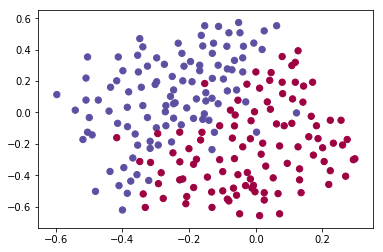

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()


In [4]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(2, 211)
(1, 211)
(2, 200)
(1, 200)


In [5]:
def sigmoid(Z):
    # sigmoid(Z) can be close to 1,but can not be 1.So clip Z to be 10 when Z bigger 10.
    Z[Z>=10]=10  
    A=1/(1+np.exp(-Z))
 
    return A,Z

In [6]:
A=1/(1+np.exp(-10))
print(A)
A=1/(1+np.exp(-40))
print(A)

0.9999546021312976
1.0


In [7]:
def relu(Z):
    A=np.maximum(0,Z)
   
    return A,Z

In [8]:
def initialize_parameter_deep(layer_dims):
    parameters={}
    np.random.seed(3)
    for l in range(1,len(layer_dims)):
        parameters["W"+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b"+str(l)]=np.zeros((layer_dims[l],1))
    
    return parameters


In [9]:
def linear_forward(A_prev,W,b):

    Z=np.dot(W,A_prev)+b
    cache=(A_prev,W,b)
    return Z,cache

In [10]:
def linear_activation_forward(A_prev,W,b,activation):
    
    if activation=="sigmoid":
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=sigmoid(Z)
    if activation=="relu":
        Z,linear_cache=linear_forward(A_prev,W,b)
        A,activation_cache=relu(Z)
   
    cache=(linear_cache,activation_cache)
    return A,cache

In [11]:
def L_model_forward(X,parameters,keep_prob=1):
    np.random.seed(1)
    caches=[]
    dropouts=[]
    layers=len(parameters)//2
    A=X
    for l in range(1,layers):
        A_prev = A 
        A,cache=linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        
        #add dropout from 1 to layers-1,ignore input and output layer
        if keep_prob<1:
            dropout=np.random.rand(A.shape[0],A.shape[1])
            
            dropout=(dropout<keep_prob)
            A=(A*dropout)/keep_prob
            dropouts.append(dropout)
        caches.append(cache)
        
    AL,cache=linear_activation_forward(A,parameters["W"+str(layers)],parameters["b"+str(layers)],"sigmoid")
    caches.append(cache)
    return AL,caches,dropouts

In [12]:
def compute_cost(AL,Y,parameters,lambd):
    m=Y.shape[1]
    cost = -np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)
    cost=np.squeeze(cost)/m
    
    L=len(parameters)//2
    R=0
    for l in range(1,L+1):
        R+=np.sum(np.square(parameters["W"+str(l)]))
    lastcost=cost+lambd*R/(2*m)
    return lastcost

In [13]:
def sigmoid_backward(dA,activation_cache):
    Z=activation_cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    return dZ

In [14]:
def relu_backward(dA,activation_cache):
    
    Z=activation_cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    return dZ   
    

In [15]:
def linear_backward(dZ,linear_cache,lambd):
    A_prev,W,b=linear_cache
    m=A_prev.shape[1]
    
    dW=(np.dot(dZ,A_prev.T)+lambd*W)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.dot(W.T,dZ)
    return dA_prev,dW,db

In [16]:
def linear_activation_backward(dA,cache,activation,lambd):
    
    
    linear_cache,activation_cache=cache
   
    if activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
    elif activation=="relu":
        dZ=relu_backward(dA,activation_cache)
    dA_prev,dW,db=linear_backward(dZ,linear_cache,lambd)

    return dA_prev,dW,db

In [17]:
def L_model_backward(AL,Y,caches,dropouts,lambd,keep_prob):
    
    grads={}
    L=len(caches)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache=caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,"sigmoid",lambd)
    if keep_prob<1:
        grads["dA"+str(L-1)]=(grads["dA"+str(L-1)]*dropouts[L-2])/keep_prob
        #print("dA="+str(L-1)+str(grads["dA"+str(L-1)]))
    for l in reversed(range(L-1)):
        current_cache=caches[l]
        grads["dA"+str(l)],grads["dW"+str(l+1)],grads["db"+str(l+1)]=linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu",lambd)
        if keep_prob<1 and l>0:
            
            grads["dA"+str(l)]=(grads["dA"+str(l)]*dropouts[l-1])/keep_prob
           # print("dA="+str(l)+str(grads["dA"+str(l)]))
    return grads

In [18]:
def update_parameters(parameters,grads,learning_rate):
    
    L=len(parameters)//2
    
    for l in range(1,L+1):
        parameters["W"+str(l)]=parameters["W"+str(l)]-learning_rate*grads["dW"+str(l)]
        parameters["b"+str(l)]=parameters["b"+str(l)]-learning_rate*grads["db"+str(l)]
        
    return parameters

In [19]:
def L_layer_model(X,Y,layers_dims,learning_rate=0.3,num_iterations=3000,print_cost=False,lambd = 0,keep_prob = 1):
    np.random.seed(1)
    costs=[]
    parameters=initialize_parameter_deep(layers_dims)
    
    
    for i in range(0,num_iterations):
        
        AL,caches,dropouts=L_model_forward(X,parameters,keep_prob)
        
        cost=compute_cost(AL,Y,parameters,lambd)
        grads=L_model_backward(AL,Y,caches,dropouts,lambd,keep_prob)
        parameters=update_parameters(parameters,grads,learning_rate)
        if print_cost and i%10000==0:
            print("interations"+str(i)+","+str(cost))
        if print_cost and i%1000==0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters
            

In [20]:
def predict(X,y,parameters,):
    
    AL,caches,dropouts=L_model_forward(X,parameters)
    m=X.shape[1]
    yhat=np.round(AL)
    
    print("Accuracy:"+str(np.sum(yhat==y)/m))
    return yhat

In [21]:
layers_dims=[2,20,3,1]

interations0,0.6557412523481002
interations10000,0.16325348629753855
interations20000,0.13934404825875427


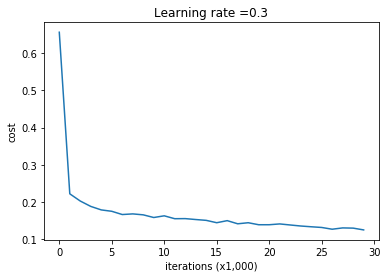

Accuracy:0.95260663507109
Accuracy:0.915


In [22]:
parameters=L_layer_model(train_X,train_Y,layers_dims,learning_rate=0.3,num_iterations=30000,print_cost=True)
pred_train = predict(train_X, train_Y, parameters,)
pred_test = predict(test_X, test_Y, parameters)

interations0,0.6974484493131264
interations10000,0.2684918873282239
interations20000,0.26809163371273004


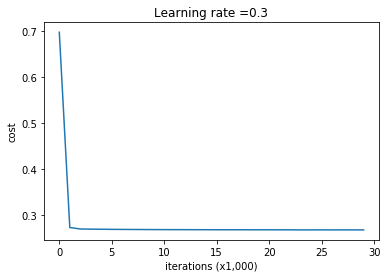

Accuracy:0.9383886255924171
Accuracy:0.93


In [23]:
parameters=L_layer_model(train_X,train_Y,layers_dims,learning_rate=0.3,num_iterations=30000,print_cost=True,lambd=0.7)
pred_train = predict(train_X, train_Y, parameters)
pred_test = predict(test_X, test_Y, parameters)

In [ ]:
parameters=L_layer_model(train_X,train_Y,layers_dims,learning_rate=0.3,num_iterations=30000,print_cost=True,keep_prob=0.86)
pred_train = predict(train_X, train_Y, parameters)
pred_test = predict(test_X, test_Y, parameters)

interations0,0.6543912405149824
